Dask is a recently developed parallel computation framework for Python providing capabilities for highly scalable computation. Dask makes it very easy to develop numerically intensive codes for high performance computing environments especially when compared with traditional approaches based on lower level languages. Given the potential advantages of reduced development time provided by Dask it is pertinent to consider whether using a low level language retains any significant benefits in terms of performance.

This document reports a benchmarking exercise comparing the performance of Dask with PBLAS, a low level linear algebra library.

The problem used for benchmarking: 

$trace(\bf{X}\bf{Y})$

Where:

$\bf{X}$ and $\bf{Y}$ are N-by-N matrices of single precision, randomly generated numbers in the range [0,1]

To achieve comparible timings for pblas and dask:

* Timings include memory allocation, random number generation, matrix multiplication, trace calculation and memory deallocation. As the only $O(N^3)$ operation, the matrix multiplication dominates the computation time.
* For PBLAS, multiple calculations were performed using different [block sizes](http://netlib.org/scalapack/slug/node186.html).
* For dask, calculations were performed using the automatically determined [chunk size](https://docs.dask.org/en/latest/array-chunks.html).
* Benchmarks were run for two values of N.
* 5 repeats were performed for each calculation with the quickest time reported in the below analysis.
* Speedups were calculated between 1 and 256 processes

The values for all considered parameters are given below, with all combinations having been run.

In [1]:
frameworks = ["pblas", "dask"]
Ns = [32768, 65536]
nprocs = [1, 4, 16, 64, 256]
dask_block_sizes = ["auto"]
pblas_block_sizes = [32, 64, 128, 256, 512, 1024]
all_block_sizes = list(map(str, pblas_block_sizes + dask_block_sizes))
repeats = list(range(5))

Before considering any results its worth noting that the development time of the Dask code was considerably less than that of PBLAS. This is despite the Dask code retaining much greater flexibility around the number of processes used and the matrix size and shape. The PBLAS code is restricted to dealing with square matrices, with edge lengths divisible by the block size, and square process grids. Considerable effort would be required allow deviation from these constraints but are all possible for free when using Dask.

Another other way in which the Dask offers considerably advantages is in its [memory management](https://distributed.dask.org/en/latest/worker.html#memory-management). We have not considered this here as this exercise focusses on a cpu intensive task. The spill-to-disk functionality of the Dask workers was disabled by configuring a large memory limit.

We start with some setup and load the timing data in order to look at the results:

In [2]:
%matplotlib notebook
from pathlib import Path

import matplotlib.pyplot as plt

from analysis_lib import block_size_plot, efficiency_plot, load_data, make_plot, speed_up, speed_up_plot

plt.style.use("seaborn")
plt.rcParams.update({"figure.titlesize": "xx-large"})

data = load_data(
    Path("results/"),
    framework=frameworks,
    N=Ns,
    nproc=nprocs,
    block_size=all_block_sizes,
    repeat=repeats
)

print(data.coords)

Coordinates:
  * framework   (framework) <U5 'pblas' 'dask'
  * N           (N) int64 32768 65536
  * nproc       (nproc) int64 1 4 16 64 256
  * block_size  (block_size) <U4 '32' '64' '128' '256' '512' '1024' 'auto'
  * repeat      (repeat) int64 0 1 2 3 4


As can be seen above the data is stored as an xarray DataArray. For a first look at the data we'll consider the speed up of each framework with increasing numbers of processes (so-called strong scaling).

In [3]:
fastest_runs = data.min(dim=["repeat", "block_size"])
speed_ups = speed_up(fastest_runs, fastest_runs.sel(nproc=1))

/home/ccaveayl/.conda/envs/dask-comp/lib/python3.8/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


First `N=32768`:

<IPython.core.display.Javascript object>


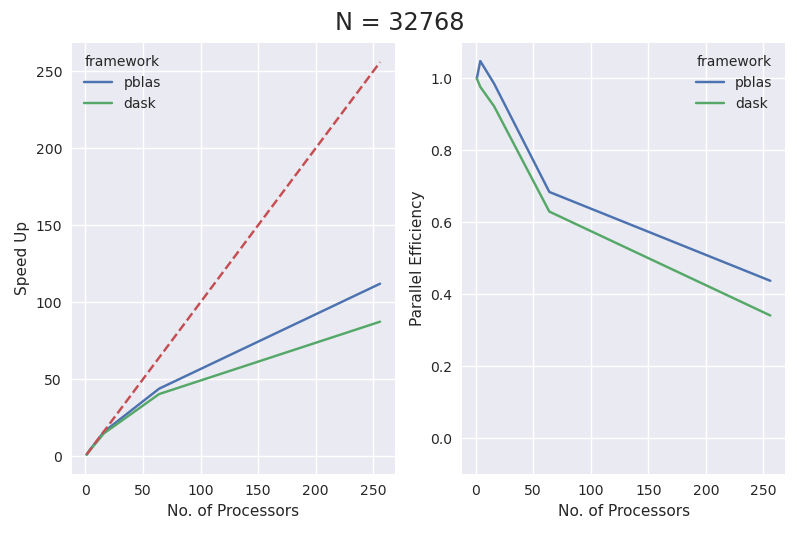

In [4]:
make_plot(speed_ups.sel(N=Ns[0]), title=f"N = {Ns[0]}", plot_types=(speed_up_plot, efficiency_plot))

Overall the observed performance is fairly comparable with PBLAS maintaining a small edge. Based on these data Dask appears to offer a compelling alternative to its lower level counterpart given its advantages in development speed and flexibility. The superlinear speed-up observed with PBLAS for `nproc=4` is consistent and does not seem to be a measurement artifact. The

<IPython.core.display.Javascript object>


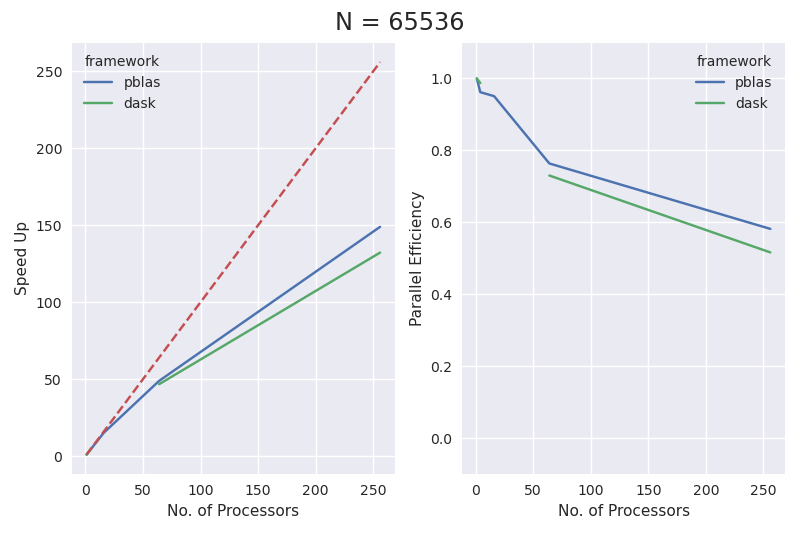

In [5]:
make_plot(speed_ups.sel(N=Ns[1]), title=f"N = {Ns[1]}", plot_types=(speed_up_plot, efficiency_plot))

Qualitatively the results for `N=65536` are comparible with the smaller problem size. A key observation however is that it was not possible to obtain a value for Dask with `nproc=16`. For this configuration Dask was consistently killed due to memory usage. No value of the chunk size parameter was found to produce viable memory consumption on available hardware.

Storing the three matrices for this problem should consume ~48GB of memory and available hardware supports jobs using up to 100GB. This suggests Dask is using more than twice the theoretical mimimum amount of memory needed for this problem (depending on the number of worker processes). This therefore raises a note of caution about the use of Dask for memory intensive applications. Whilst this analysis has not included the ability of Dask to spill data to disk, using such functionality will no-doubt come with a significant performance hit. See also the discussion below about the use of processes vs threads for Dask workers.

Another accusation that could be levelled is that we've weighted things in favour of PBLAS by considering a range of block sizes. How plausible is it that, when using a code in production, one can pick the optimal block size for any given problem? The below analysis considers the impact of block size on the recorded timings:

<IPython.core.display.Javascript object>


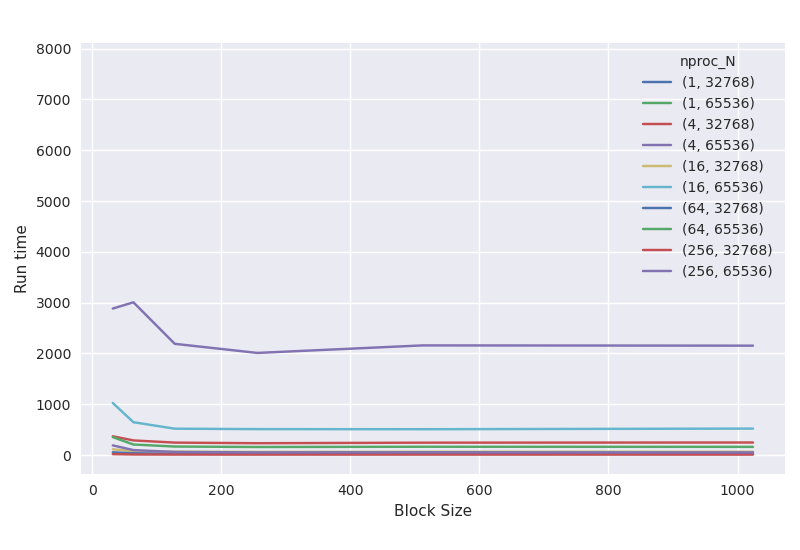

/home/ccaveayl/.conda/envs/dask-comp/lib/python3.8/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [6]:
# In order to plot with block_size, coordinate values for this dimension must be numbers
numerical_block_size_data = data.drop_sel(block_size="auto").assign_coords(block_size=pblas_block_sizes)
make_plot(
    numerical_block_size_data.sel(framework="pblas").stack(nproc_N=("nproc", "N")),
    plot_types=(block_size_plot,)
)

This analysis suggests that, once determined, a single block size value can be used to provide optimal (or near optimal performance) across different problem sizes and proccess counts. The need to manually specify a block size therefore doesn't appear to be a significant obstacle to the use of PBLAS. Whilst an equivalent analysis using Dask would have been interesting, manual setting of the chunk size frequently produced memory problems.

Some other observations on Dask:
* Use of the [dask-mpi](https://github.com/dask/dask-mpi) was by far the easiest method to setup a distributed worker pool across nodes
* In the case of failure Dask would sometimes not exit cleanly but hang with idle workers until the end of a job
* Despite a limit being placed of a single thread per worker these processes were often observed at greater than 100% CPU utilisation

Further areas for investigation:
* How performance is impacted by use of less idealised proccess grids and problem sizes
* Identify reasons why Dask is slower (overheads of scheduler + worker communication?)
* Consider different mixtures of threads and processes for both Dask and PBLAS